In [2]:
from fastai.tabular.all import *

# Load the csv
df = pd.read_csv('./date_hood_thefts_filled.csv',
                 names=["date", "hood_id", "thefts"])
df.head()


/Users/pika/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


date  hood_id  thefts
0  2015-01-01        0       0
1  2015-01-01        1       0
2  2015-01-01        2       0
3  2015-01-01        3       0
4  2015-01-01        4       0

In [3]:
# Transform the date column to a datetime object
make_date(df, 'date')
df.head()


date  hood_id  thefts
0 2015-01-01        0       0
1 2015-01-01        1       0
2 2015-01-01        2       0
3 2015-01-01        3       0
4 2015-01-01        4       0

In [4]:
# Feature engineer the date column and separate by different variables
add_datepart(df, 'date')
df.head()

hood_id  thefts  Year  Month  Week  Day  Dayofweek  Dayofyear  \
0        0       0  2015      1     1    1          3          1   
1        1       0  2015      1     1    1          3          1   
2        2       0  2015      1     1    1          3          1   
3        3       0  2015      1     1    1          3          1   
4        4       0  2015      1     1    1          3          1   

   Is_month_end  Is_month_start  Is_quarter_end  Is_quarter_start  \
0         False            True           False              True   
1         False            True           False              True   
2         False            True           False              True   
3         False            True           False              True   
4         False            True           False              True   

   Is_year_end  Is_year_start       Elapsed  
0        False           True  1.420070e+09  
1        False           True  1.420070e+09  
2        False           True  1.420070e+09  
3        False           True  1.420070e+09  
4        False           True  1.420070e+09

In [27]:
# Split the data into train and validation sets where the end of the set is the validation set
splits = EndSplitter(valid_pct=0.4, valid_last=True)(range_of(df))

# Create a TabularPandas object
tabular_pandas = TabularPandas(
    df, procs=[Categorify, FillMissing, Normalize],
    cat_names=['hood_id', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
               'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'],
    cont_names=[],
    y_names="thefts", y_block=CategoryBlock,
    splits=splits)

tabular_pandas.xs.iloc[:5]


/Users/pika/.pyenv/versions/3.9.13/lib/python3.9/site-packages/fastai/tabular/core.py:279: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  to.conts = (to.conts-self.means) / self.stds


hood_id  Year  Month  Week  Day  Dayofweek  Dayofyear  Is_month_end  \
0        1     1      1     1    1          4          1             1   
1        2     1      1     1    1          4          1             1   
2        3     1      1     1    1          4          1             1   
3        4     1      1     1    1          4          1             1   
4        5     1      1     1    1          4          1             1   

   Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end  \
0               2               1                 2            1   
1               2               1                 2            1   
2               2               1                 2            1   
3               2               1                 2            1   
4               2               1                 2            1   

   Is_year_start  
0              2  
1              2  
2              2  
3              2  
4              2

In [36]:
# Set the batch size
data_loader = tabular_pandas.dataloaders(bs=2000)
data_loader.show_batch()

/Users/pika/.pyenv/versions/3.9.13/lib/python3.9/site-packages/fastai/tabular/core.py:284: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  to.conts = (to.conts*self.stds ) + self.means


In [51]:
# Create a model with cross entropy loss
learn = tabular_learner(data_loader, layers=[
                        200, 200, 200], y_range=(0, 4), loss_func=CrossEntropyLossFlat())


In [52]:
# Train the model
learn.fit_one_cycle(4)


In [53]:
# Show the results
learn.show_results(max_n=50)


In [54]:
# Get the predictions and target values
preds, targs = learn.get_preds()
print(preds)
print(targs)


tensor([[0.7519, 0.1730, 0.0243, 0.0169, 0.0171, 0.0168],
        [0.7351, 0.1936, 0.0218, 0.0164, 0.0163, 0.0168],
        [0.8261, 0.1029, 0.0192, 0.0174, 0.0173, 0.0172],
        ...,
        [0.9026, 0.0206, 0.0197, 0.0193, 0.0190, 0.0188],
        [0.9051, 0.0201, 0.0186, 0.0188, 0.0187, 0.0187],
        [0.9027, 0.0198, 0.0191, 0.0196, 0.0194, 0.0194]])
tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int8)


In [55]:
# Get the highest value from the predictions tensor
preds = preds.argmax(dim=-1)
print(preds)

tensor([0, 0, 0,  ..., 0, 0, 0])


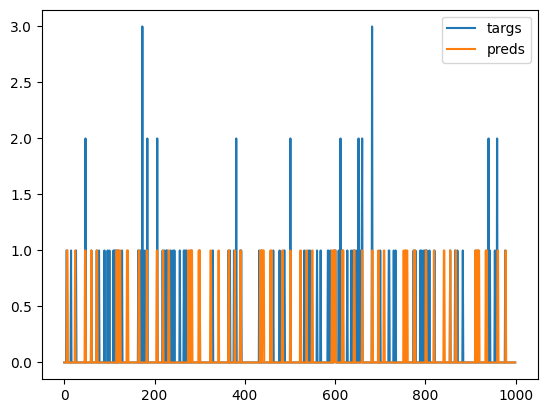

In [57]:
# Plot only the highest predictions vs target in a line plot las 4000 values
plt.plot(targs[-1000:].numpy(), label='targs')
plt.plot(preds[-1000:].numpy(), label='preds')
plt.legend()
plt.show()

In [58]:
# With sckiit-learn calculate the mean squared error and accuracy
from sklearn.metrics import mean_squared_error, accuracy_score

# Round the predictions to the nearest integer
preds = np.round(preds)

print('Mean squared error: ', mean_squared_error(targs, preds))
print('Accuracy: ', accuracy_score(targs, preds))

Mean squared error:  0.2243139372562086
Accuracy:  0.8185186674556078
